In [1]:
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.base import clone
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("radiomic_features.csv")

In [3]:
X = df.drop(["ID", "idh_mutated", "gbma"], axis=1)
y = df["idh_mutated"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Feature filtering

In [5]:
# Best features identified by Calabrese et al. (2020)
filtered_features = ["original_shape_SurfaceVolumeRatio", "original_ngtdm_Coarseness", "original_gldm_HighGrayLevelEmphasis", "original_firstorder_Kurtosis"]

In [6]:
def sensit_recall(res):
    tn, fp, fn, tp = res.ravel()
    return tp / (tp + fn)

def precision(res):
    tn, fp, fn, tp = res.ravel()
    return tp/ (tp + fp)

def f1(res):
    prec = precision(res)
    recall= sensit_recall(res)
    return (2 * prec * recall) / (precision + recall)

def calculate_mcc(res):
    tn, fp, fn, tp = res.ravel()
    nominator = tp * tn - fp * fn
    denum = ((tp + fp)*(tp + fn)*(tn + fp) * (tn+fn)) ** (1/2)
    return nominator / denum


In [35]:
class ModelTraining:
    def __init__(self, estimator, scaler, data_X, data_y, random_state=42):
        self.data_X, self.data_y = data_X, data_y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=random_state)
        
        self.original_estimator = clone(estimator)
        self.estimator = estimator
        self.original_scaler = clone(scaler)
        self.scaler = scaler

        self.feature_columns = data_X.columns

    def fit_scaler(self, X=None):
        if X is None:
            X = self.X_train
        return self.scaler.fit_transform(X)

    def scale_features(self, X=None):
        if X is None:
            X = self.X_test
        
        return self.scaler.transform(X)
    
    def train(self, X=None, y=None):
        if X is None or y is None:
            X = self.X_train
            y = self.y_train

        self.estimator.fit(X, y)

    def cross_validate(self, X=None, y=None, cv_model=None, random_state=42, select_features=10, features_strict=True, repeats=2):
        if X is None or y is None:
            X = self.data_X
            y = self.data_y
        if cv_model is None:
            cv_model = RepeatedKFold(n_splits=3, n_repeats=2, random_state=random_state)
        
        accuracies = []
        confusion_matrices = []

        self.estimator = clone(self.original_estimator)
        self.X_train = self.fit_scaler()
        self.X_test = self.scale_features()
        feature_mask = self.select_features(self.X_train, self.y_train, select_features=select_features, features_strict=features_strict, random_seed=random_state)
        X = X.loc[:, feature_mask]

        for i, (train, test) in enumerate(cv_model.split(X, y)):
            train_X, train_y = X.iloc[train, :], y[train]
            test_X, test_y = X.iloc[test, :], y[test]

            self.scaler = clone(self.original_scaler)
            train_X = self.fit_scaler(train_X)
            test_X = self.scale_features(test_X)

            # Feature Selection
            estimator = clone(self.original_estimator)

            estimator.fit(train_X, train_y)
            test_predictions = estimator.predict(test_X)

            acc = accuracy_score(test_y, test_predictions)
            print(f"Accuracy (one split): {acc:.3f}")
            accuracies.append(acc)
            confusion_matrices.append(confusion_matrix(test_y, test_predictions))
        
        print(accuracies)

        conf_matrix = np.array(confusion_matrices).mean(axis=0)
        print(conf_matrix)
        
        tn, fp, fn, tp = conf_matrix.ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)

        print(f"Accuracy: {np.mean(accuracies):.3f}")
        print(f"\nSpecificity: {specificity:.3f}")
        print(f"\nPrecision: {precision:.3f}")
        print(f"\nSensitivity (Recall): {sensitivity:.3f}")

        mcc = ((tp * tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        print(f"\nMCC: {mcc:.3f}")
        return conf_matrix
    
    def cross_validate2(self, X=None, y=None, cv_model=None, random_state=42, select_features=10, features_strict=True, repeats=2):
        if X is None or y is None:
            X = self.data_X
            y = self.data_y
        if cv_model is None:
            cv_model = RepeatedKFold(n_splits=3, n_repeats=2, random_state=random_state)
        
        accuracies = []
        confusion_matrices = []

        self.estimator = clone(self.original_estimator)
        #self.X_train = self.fit_scaler()
        #self.X_test = self.scale_features()
        #feature_mask = self.select_features(self.X_train, self.y_train, select_features=select_features, features_strict=features_strict, random_seed=random_state)
        #X = X.loc[:, feature_mask]

        for i, (train, test) in enumerate(cv_model.split(X, y)):
            train_X, train_y = X.iloc[train, :], y[train]
            test_X, test_y = X.iloc[test, :], y[test]

            self.scaler = clone(self.original_scaler)
            train_X = self.fit_scaler(train_X)
            test_X = self.scale_features(test_X)

            # Feature Selection
            self.estimator = clone(self.original_estimator)
            print(f"{i+1}. Split: Selecting features")
            feature_mask = self.select_features(train_X, train_y, select_features=select_features, features_strict=features_strict, random_seed=random_state)
            train_X = train_X[:, feature_mask]
            test_X = test_X[:, feature_mask]

            estimator = clone(self.original_estimator)

            estimator.fit(train_X, train_y)
            test_predictions = estimator.predict(test_X)

            acc = accuracy_score(test_y, test_predictions)
            print(f"Accuracy (one split): {acc:.3f}")
            accuracies.append(acc)
            confusion_matrices.append(confusion_matrix(test_y, test_predictions))
        
        print(accuracies)

        conf_matrix = np.array(confusion_matrices).mean(axis=0)
        print(conf_matrix)
        
        tn, fp, fn, tp = conf_matrix.ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)

        print(f"Accuracy: {np.mean(accuracies):.3f}")
        print(f"\nSpecificity: {specificity:.3f}")
        print(f"\nPrecision: {precision:.3f}")
        print(f"\nSensitivity (Recall): {sensitivity:.3f}")

        mcc = ((tp * tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        print(f"\nMCC: {mcc:.3f}")
        return mcc

    
    def predict(self, X=None):
        if X is None:
            X = self.X_test
        return self.estimator.predict(X)
    
    def select_features(self, X=None, y=None, step=0.01, select_features=10, features_strict=True, random_seed=None):
        if X is None or y is None:
            X = self.X_train
            y = self.y_train

        self.selector = RFECV(self.estimator, step=step, min_features_to_select=select_features)
        self.selector.fit(X, y)

        if features_strict:
            worst_ranking = np.sort(self.selector.ranking_)[select_features]
            best_features_mask = self.selector.ranking_ <= worst_ranking
            if random_seed is None:
                # Important: this can remove optimal features
                return best_features_mask & (np.cumsum(best_features_mask) <= select_features)
            else:
                np.random.seed(random_seed)
                true_indices = np.where(best_features_mask)[0]
                selected_indices = np.random.choice(true_indices, size=select_features, replace=False)
                new_mask = np.zeros_like(best_features_mask, dtype=bool)
                new_mask[selected_indices] = True
                return new_mask

        return self.selector.support_


    def train_and_evaluate(self, select_features=10, features_strict=True):
        self.X_train = self.fit_scaler()
        print("Scaler fitted")
        self.X_test = self.scale_features()
        print("Test features scaled")

        if select_features is not None:
            feature_mask = self.select_features(self.X_train, select_features=select_features, features_strict=features_strict)
            self.X_train = self.X_train[:, feature_mask]
            self.X_test = self.X_test[:, feature_mask]
            
            print(f"Selected {sum(feature_mask)} features.")

            if len(feature_mask) == len(self.feature_columns):
                print("Selected features:")
                print("\n".join(self.feature_columns[feature_mask]))

        self.estimator = clone(self.original_estimator)
        self.train(self.X_train, self.y_train)
        print("Training finished")
        train_predictions = self.predict(self.X_train)
        test_predictions = self.predict(self.X_test)

        print("\nTraining:")
        print(f"Accuracy: {accuracy_score(self.y_train, train_predictions):.3f}")

        print(f"\nMCC: {matthews_corrcoef(self.y_train, train_predictions):.3f}")

        print("\n\nTest:")
        print("Confusion Matrix:")
        test_matrix = confusion_matrix(self.y_test, test_predictions)
        print(test_matrix)


        print(f"\nAccuracy: {accuracy_score(self.y_test, test_predictions):.3f}")

        tn, fp, fn, tp = test_matrix.ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)

        print(f"\nSpecificity: {specificity:.3f}")
        print(f"\nPrecision: {precision:.3f}")
        print(f"\nSensitivity (Recall): {sensitivity:.3f}")


        print(f"\nMCC: {matthews_corrcoef(y_test, test_predictions):.3f}")

## Logistic Regression

In [43]:
mccs = []
solvers_penalties = [("saga", "elasticnet"), ("saga", "l1"), 
                     ("lbfgs", "l2"), ("sag", "l2"), 
                     ("liblinear", "l2"), ("liblinear", "l1")]

solver, penalty = solvers_penalties[0]
for l1_ratio in [0.3]:
    feature_specific_mccs = []
    
    """
    if penalty == "elasticnet":
        l1_ratio = 0.5
    else:
        l1_ratio = None"""

    for random_state in range(20, 150, 10):
        log_reg = ModelTraining(LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1_ratio), StandardScaler(), data_X=X, data_y=y)

        print("Logistic Regression:")
        mcc = log_reg.cross_validate(X, y, select_features=140, random_state=random_state, repeats=9)
        feature_specific_mccs.append(np.round(mcc, 2))
    mccs.append(feature_specific_mccs)
mccs


Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.850
Accuracy (one split): 0.850
Accuracy (one split): 0.800
Accuracy (one split): 0.800
Accuracy (one split): 0.750
Accuracy (one split): 0.750
[0.85, 0.85, 0.8, 0.8, 0.75, 0.75]
[[7.66666667 2.33333333]
 [1.66666667 8.33333333]]
Accuracy: 0.800

Specificity: 0.767

Precision: 0.781

Sensitivity (Recall): 0.833

MCC: 0.601
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.800
Accuracy (one split): 0.800
Accuracy (one split): 0.700
Accuracy (one split): 0.800
Accuracy (one split): 0.800
Accuracy (one split): 0.800
[0.8, 0.8, 0.7, 0.8, 0.8, 0.8]
[[7.83333333 2.16666667]
 [2.16666667 7.83333333]]
Accuracy: 0.783

Specificity: 0.783

Precision: 0.783

Sensitivity (Recall): 0.783

MCC: 0.567
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.800
Accuracy (one split): 0.750
Accuracy (one split): 0.950
Accuracy (one split): 0.800
Accuracy (one split): 0.900
Accuracy (one split): 0.900
[0.8, 0.75, 0.95, 0.8, 0.9, 0.9]
[[8. 2.]
 [1. 9.]]
Accuracy: 0.850

Specificity: 0.800

Precision: 0.818

Sensitivity (Recall): 0.900

MCC: 0.704
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.800
Accuracy (one split): 0.900
Accuracy (one split): 0.850
Accuracy (one split): 0.850
Accuracy (one split): 0.900
Accuracy (one split): 0.800
[0.8, 0.9, 0.85, 0.85, 0.9, 0.8]
[[8.5 1.5]
 [1.5 8.5]]
Accuracy: 0.850

Specificity: 0.850

Precision: 0.850

Sensitivity (Recall): 0.850

MCC: 0.700
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.850
Accuracy (one split): 0.850
Accuracy (one split): 0.900
Accuracy (one split): 0.800
Accuracy (one split): 0.750
Accuracy (one split): 0.800
[0.85, 0.85, 0.9, 0.8, 0.75, 0.8]
[[8.  2. ]
 [1.5 8.5]]
Accuracy: 0.825

Specificity: 0.800

Precision: 0.810

Sensitivity (Recall): 0.850

MCC: 0.651
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.850
Accuracy (one split): 0.800
Accuracy (one split): 0.950
Accuracy (one split): 0.850
Accuracy (one split): 0.850
Accuracy (one split): 0.850
[0.85, 0.8, 0.95, 0.85, 0.85, 0.85]
[[8.66666667 1.33333333]
 [1.5        8.5       ]]
Accuracy: 0.858

Specificity: 0.867

Precision: 0.864

Sensitivity (Recall): 0.850

MCC: 0.717
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.900
Accuracy (one split): 0.850
Accuracy (one split): 0.750
Accuracy (one split): 0.850
Accuracy (one split): 0.800
Accuracy (one split): 0.850
[0.9, 0.85, 0.75, 0.85, 0.8, 0.85]
[[8.         2.        ]
 [1.33333333 8.66666667]]
Accuracy: 0.833

Specificity: 0.800

Precision: 0.812

Sensitivity (Recall): 0.867

MCC: 0.668
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.900
Accuracy (one split): 0.850
Accuracy (one split): 0.900
Accuracy (one split): 0.800
Accuracy (one split): 0.900
Accuracy (one split): 0.850
[0.9, 0.85, 0.9, 0.8, 0.9, 0.85]
[[8.66666667 1.33333333]
 [1.33333333 8.66666667]]
Accuracy: 0.867

Specificity: 0.867

Precision: 0.867

Sensitivity (Recall): 0.867

MCC: 0.733
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.800
Accuracy (one split): 0.900
Accuracy (one split): 0.900
Accuracy (one split): 0.600
Accuracy (one split): 0.800
Accuracy (one split): 0.850
[0.8, 0.9, 0.9, 0.6, 0.8, 0.85]
[[8.         2.        ]
 [1.83333333 8.16666667]]
Accuracy: 0.808

Specificity: 0.800

Precision: 0.803

Sensitivity (Recall): 0.817

MCC: 0.617
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.800
Accuracy (one split): 0.900
Accuracy (one split): 0.750
Accuracy (one split): 0.950
Accuracy (one split): 0.850
Accuracy (one split): 0.800
[0.8, 0.9, 0.75, 0.95, 0.85, 0.8]
[[8.33333333 1.66666667]
 [1.5        8.5       ]]
Accuracy: 0.842

Specificity: 0.833

Precision: 0.836

Sensitivity (Recall): 0.850

MCC: 0.683
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.900
Accuracy (one split): 0.800
Accuracy (one split): 0.800
Accuracy (one split): 0.750
Accuracy (one split): 0.900
Accuracy (one split): 0.900
[0.9, 0.8, 0.8, 0.75, 0.9, 0.9]
[[9.16666667 0.83333333]
 [2.33333333 7.66666667]]
Accuracy: 0.842

Specificity: 0.917

Precision: 0.902

Sensitivity (Recall): 0.767

MCC: 0.691
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.800
Accuracy (one split): 0.850
Accuracy (one split): 0.950
Accuracy (one split): 0.750
Accuracy (one split): 0.850
Accuracy (one split): 0.950
[0.8, 0.85, 0.95, 0.75, 0.85, 0.95]
[[8.5        1.5       ]
 [1.33333333 8.66666667]]
Accuracy: 0.858

Specificity: 0.850

Precision: 0.852

Sensitivity (Recall): 0.867

MCC: 0.717
Logistic Regression:


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Accuracy (one split): 0.750
Accuracy (one split): 0.850
Accuracy (one split): 0.750
Accuracy (one split): 0.900
Accuracy (one split): 0.750
Accuracy (one split): 0.750
[0.75, 0.85, 0.75, 0.9, 0.75, 0.75]
[[8.16666667 1.83333333]
 [2.33333333 7.66666667]]
Accuracy: 0.792

Specificity: 0.817

Precision: 0.807

Sensitivity (Recall): 0.767

MCC: 0.584


c:\Users\standakozak\anaconda3\envs\radiomics\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[[array([[7.67, 2.33],
         [1.67, 8.33]]),
  array([[7.83, 2.17],
         [2.17, 7.83]]),
  array([[8., 2.],
         [1., 9.]]),
  array([[8.5, 1.5],
         [1.5, 8.5]]),
  array([[8. , 2. ],
         [1.5, 8.5]]),
  array([[8.67, 1.33],
         [1.5 , 8.5 ]]),
  array([[8.  , 2.  ],
         [1.33, 8.67]]),
  array([[8.67, 1.33],
         [1.33, 8.67]]),
  array([[8.  , 2.  ],
         [1.83, 8.17]]),
  array([[8.33, 1.67],
         [1.5 , 8.5 ]]),
  array([[9.17, 0.83],
         [2.33, 7.67]]),
  array([[8.5 , 1.5 ],
         [1.33, 8.67]]),
  array([[8.17, 1.83],
         [2.33, 7.67]])]]

In [45]:

complete_matrix = np.mean(mccs, axis=1)
print("Precision:", precision(complete_matrix))
print("Recall: ", sensit_recall(complete_matrix))
print("MCC: ", calculate_mcc(complete_matrix))

Precision: 0.8285431119920715
Recall:  0.836
MCC:  0.6630268531313388


In [16]:
# First version (Feature Selection for whole CV) - cross_validate
# 2 Splits only, 600 features
# (0.518, 0.066)

# Feature Selection for every CV (cross_validate2)
# 2 Splits, 600 Features
# (0.4666666666666667, 0.06280481227138925)

#  cross_validate, 2 Splits, 200 Features
# 0.591, 0.0645

#  cross_validate, 2 Splits, 150 Features
# 0.592, 0.0576

# cross_validate, 10 Splits, 120 Features
# 0.603, 0.0613

# saga - elasticnet, l1_ratio=0.5, 15 splits, 140 Features
# 0.615, 0.0597

# saga - elasticnet, l1_ratio=0.25, 15 splits, 140 Features
# (0.645, 0.0595), (0.661, 0.0470) !!!!

# saga - elasticnet, l1_ratio=0.3, 15 splits, 140 Features
# 0.644, 0.0666


np.mean(mccs, axis=1), np.std(mccs, axis=1)

(array([0.64538462, 0.66153846, 0.66153846, 0.66384615]),
 array([0.04550831, 0.04704272, 0.0381991 , 0.05284789]))

In [8]:
# MCC 0.503
# log_reg.train_and_evaluate(select_features=500)

log_reg = ModelTraining(LogisticRegression(), StandardScaler(), data_X=X, data_y=y)

print("Logistic Regression:")
log_reg.train_and_evaluate(select_features=500)


Logistic Regression:
Scaler fitted
Test features scaled
Selected 500 features.
Selected features:
original_firstorder_10Percentile_ADC_tumor_segmentation
original_firstorder_10Percentile_DTI_eddy_MD_brain_segmentation
original_firstorder_10Percentile_DTI_eddy_MD_tumor_segmentation
original_firstorder_10Percentile_DWI_bias_brain_segmentation
original_firstorder_10Percentile_DWI_bias_tumor_segmentation
original_firstorder_10Percentile_T1c_bias_brain_segmentation
original_firstorder_10Percentile_T1c_bias_tumor_segmentation
original_firstorder_90Percentile_ADC_tumor_segmentation
original_firstorder_90Percentile_DTI_eddy_MD_tumor_segmentation
original_firstorder_90Percentile_DWI_bias_tumor_segmentation
original_firstorder_90Percentile_T1c_bias_brain_segmentation
original_firstorder_90Percentile_T1c_bias_tumor_segmentation
original_firstorder_Energy_ADC_tumor_segmentation
original_firstorder_Energy_DTI_eddy_MD_tumor_segmentation
original_firstorder_Energy_DWI_bias_brain_segmentation
original

## Support Vector Machines

In [46]:
#svm = ModelTraining(SVC(kernel="linear"), StandardScaler(), data_X=X, data_y=y)
#mcc = svm.cross_validate(X, y, select_features=500, random_state=13, repeats=3)

mccs = []
penalties_losses = [("l2", "squared_hinge"), ("l2", "hinge"), ("l1", "squared_hinge")]
penalty, loss = penalties_losses[0]
for tol in [0.0001]:
    feature_specific_mccs = []

    dual = "auto"
    if penalty == "l1" or loss == "hinge":
        dual = False

    if penalty == "l2":
        dual = True
    
    for random_state in range(20, 150, 10):
        svm = ModelTraining(LinearSVC(penalty=penalty, loss=loss, dual=dual, tol=tol), StandardScaler(), data_X=X, data_y=y)

        print("SVM:")
        mcc = svm.cross_validate(X, y, select_features=140, random_state=random_state, repeats=9)
        feature_specific_mccs.append(np.round(mcc, 2))
    mccs.append(feature_specific_mccs)
mccs

SVM:
Accuracy (one split): 0.700
Accuracy (one split): 0.900
Accuracy (one split): 0.700
Accuracy (one split): 0.750
Accuracy (one split): 0.750
Accuracy (one split): 0.850
[0.7, 0.9, 0.7, 0.75, 0.75, 0.85]
[[7.33333333 2.66666667]
 [1.83333333 8.16666667]]
Accuracy: 0.775

Specificity: 0.733

Precision: 0.754

Sensitivity (Recall): 0.817

MCC: 0.552
SVM:
Accuracy (one split): 0.800
Accuracy (one split): 0.850
Accuracy (one split): 0.850
Accuracy (one split): 0.750
Accuracy (one split): 0.850
Accuracy (one split): 0.700
[0.8, 0.85, 0.85, 0.75, 0.85, 0.7]
[[8. 2.]
 [2. 8.]]
Accuracy: 0.800

Specificity: 0.800

Precision: 0.800

Sensitivity (Recall): 0.800

MCC: 0.600
SVM:
Accuracy (one split): 0.700
Accuracy (one split): 0.700
Accuracy (one split): 0.950
Accuracy (one split): 0.800
Accuracy (one split): 0.650
Accuracy (one split): 0.900
[0.7, 0.7, 0.95, 0.8, 0.65, 0.9]
[[7.33333333 2.66666667]
 [1.66666667 8.33333333]]
Accuracy: 0.783

Specificity: 0.733

Precision: 0.758

Sensitivity (

[[array([[7.33, 2.67],
         [1.83, 8.17]]),
  array([[8., 2.],
         [2., 8.]]),
  array([[7.33, 2.67],
         [1.67, 8.33]]),
  array([[8.17, 1.83],
         [3.  , 7.  ]]),
  array([[7., 3.],
         [2., 8.]]),
  array([[8.5, 1.5],
         [2.5, 7.5]]),
  array([[7.67, 2.33],
         [1.83, 8.17]]),
  array([[8.5, 1.5],
         [3. , 7. ]]),
  array([[8.5 , 1.5 ],
         [1.83, 8.17]]),
  array([[8.  , 2.  ],
         [1.83, 8.17]]),
  array([[8.33, 1.67],
         [2.83, 7.17]]),
  array([[7.83, 2.17],
         [1.83, 8.17]]),
  array([[8.17, 1.83],
         [2.33, 7.67]])]]

In [47]:
complete_matrix = np.mean(mccs, axis=1)
print("Precision:", precision(complete_matrix))
print("Recall: ", sensit_recall(complete_matrix))
print("MCC: ", calculate_mcc(complete_matrix))

Precision: 0.7919494500351041
Recall:  0.780923076923077
MCC:  0.575825045913176


In [34]:
# 140 Features, l2 - squared_hinge - dual=True
# 0.5769, 0.042
np.mean(mccs, axis=1), np.std(mccs, axis=1)

(array([0.57538462, 0.57692308, 0.57692308]),
 array([0.02951281, 0.0421325 , 0.0421325 ]))

In [10]:
# 20 Features -> MCC 0.394
# 200 Features -> MCC 0.594
svm = ModelTraining(SVC(kernel="linear"), StandardScaler(), data_X=X, data_y=y)

print("Support Vector Classifier:")
svm.train_and_evaluate(select_features=200)

Support Vector Classifier:
Scaler fitted
Test features scaled
Selected 200 features.
Selected features:
original_firstorder_10Percentile_ADC_tumor_segmentation
original_firstorder_10Percentile_DTI_eddy_MD_brain_segmentation
original_firstorder_10Percentile_DTI_eddy_MD_tumor_segmentation
original_firstorder_10Percentile_DWI_bias_tumor_segmentation
original_firstorder_10Percentile_T1c_bias_brain_segmentation
original_firstorder_90Percentile_DTI_eddy_MD_tumor_segmentation
original_firstorder_90Percentile_DWI_bias_tumor_segmentation
original_firstorder_90Percentile_T1c_bias_brain_segmentation
original_firstorder_90Percentile_T1c_bias_tumor_segmentation
original_firstorder_Energy_T1c_bias_brain_segmentation
original_firstorder_InterquartileRange_DWI_bias_tumor_segmentation
original_firstorder_InterquartileRange_T1c_bias_brain_segmentation
original_firstorder_InterquartileRange_T1c_bias_tumor_segmentation
original_firstorder_Kurtosis_ADC_tumor_segmentation
original_firstorder_Kurtosis_DWI_bi

## Random Forest Classifier

In [11]:
clf = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=42)
rfc = ModelTraining(clf, StandardScaler(), data_X=X, data_y=y)

print("Random Forest Classifiers:")
rfc.cross_validate(X, y, select_features=10, random_state=13)

Random Forest Classifiers:
Accuracy (one split): 0.750
Accuracy (one split): 0.500
Accuracy (one split): 0.600
Accuracy (one split): 0.650
Accuracy (one split): 0.600
Accuracy (one split): 0.600
[0.75, 0.5, 0.6, 0.65, 0.6, 0.6]
[[5.33333333 4.66666667]
 [3.         7.        ]]
Accuracy: 0.617

Specificity: 0.533

Precision: 0.600

Sensitivity (Recall): 0.700

MCC: 0.237


0.2366431913239846

In [13]:
print("Random Forest Classifier:")
clf = RandomForestClassifier(max_depth=4, n_estimators=25, random_state=42)
rfc = ModelTraining(clf, StandardScaler(), data_X=X, data_y=y)
rfc.train_and_evaluate(select_features=10)

Random Forest Classifier:
Scaler fitted
Test features scaled
Selected 10 features.
Selected features:
original_firstorder_Kurtosis_DWI_bias_brain_segmentation
original_firstorder_Kurtosis_DWI_bias_tumor_segmentation
original_firstorder_Kurtosis_T1c_bias_brain_segmentation
original_firstorder_Kurtosis_T1c_bias_tumor_segmentation
original_firstorder_Maximum_ADC_brain_segmentation
original_firstorder_Maximum_ADC_tumor_segmentation
original_firstorder_Maximum_DTI_eddy_MD_brain_segmentation
original_firstorder_Maximum_DTI_eddy_MD_tumor_segmentation
original_firstorder_Maximum_DWI_bias_brain_segmentation
original_firstorder_Maximum_DWI_bias_tumor_segmentation
Training finished

Training:
Accuracy: 0.975

MCC: 0.951


Test:
Confusion Matrix:
[[7 4]
 [3 6]]

Accuracy: 0.650

Specificity: 0.636

Precision: 0.600

Sensitivity (Recall): 0.667

MCC: 0.302


### Visualization of a random sampled tree

[Text(0.3333333333333333, 0.875, 'X[5] <= -0.529\ngini = 0.489\nsamples = 26\nvalue = [23, 17]'),
 Text(0.16666666666666666, 0.625, 'gini = 0.0\nsamples = 8\nvalue = [0, 14]'),
 Text(0.5, 0.625, 'X[2] <= -1.611\ngini = 0.204\nsamples = 18\nvalue = [23, 3]'),
 Text(0.3333333333333333, 0.375, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.6666666666666666, 0.375, 'X[0] <= -1.173\ngini = 0.08\nsamples = 16\nvalue = [23, 1]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.8333333333333334, 0.125, 'gini = 0.0\nsamples = 15\nvalue = [23, 0]')]

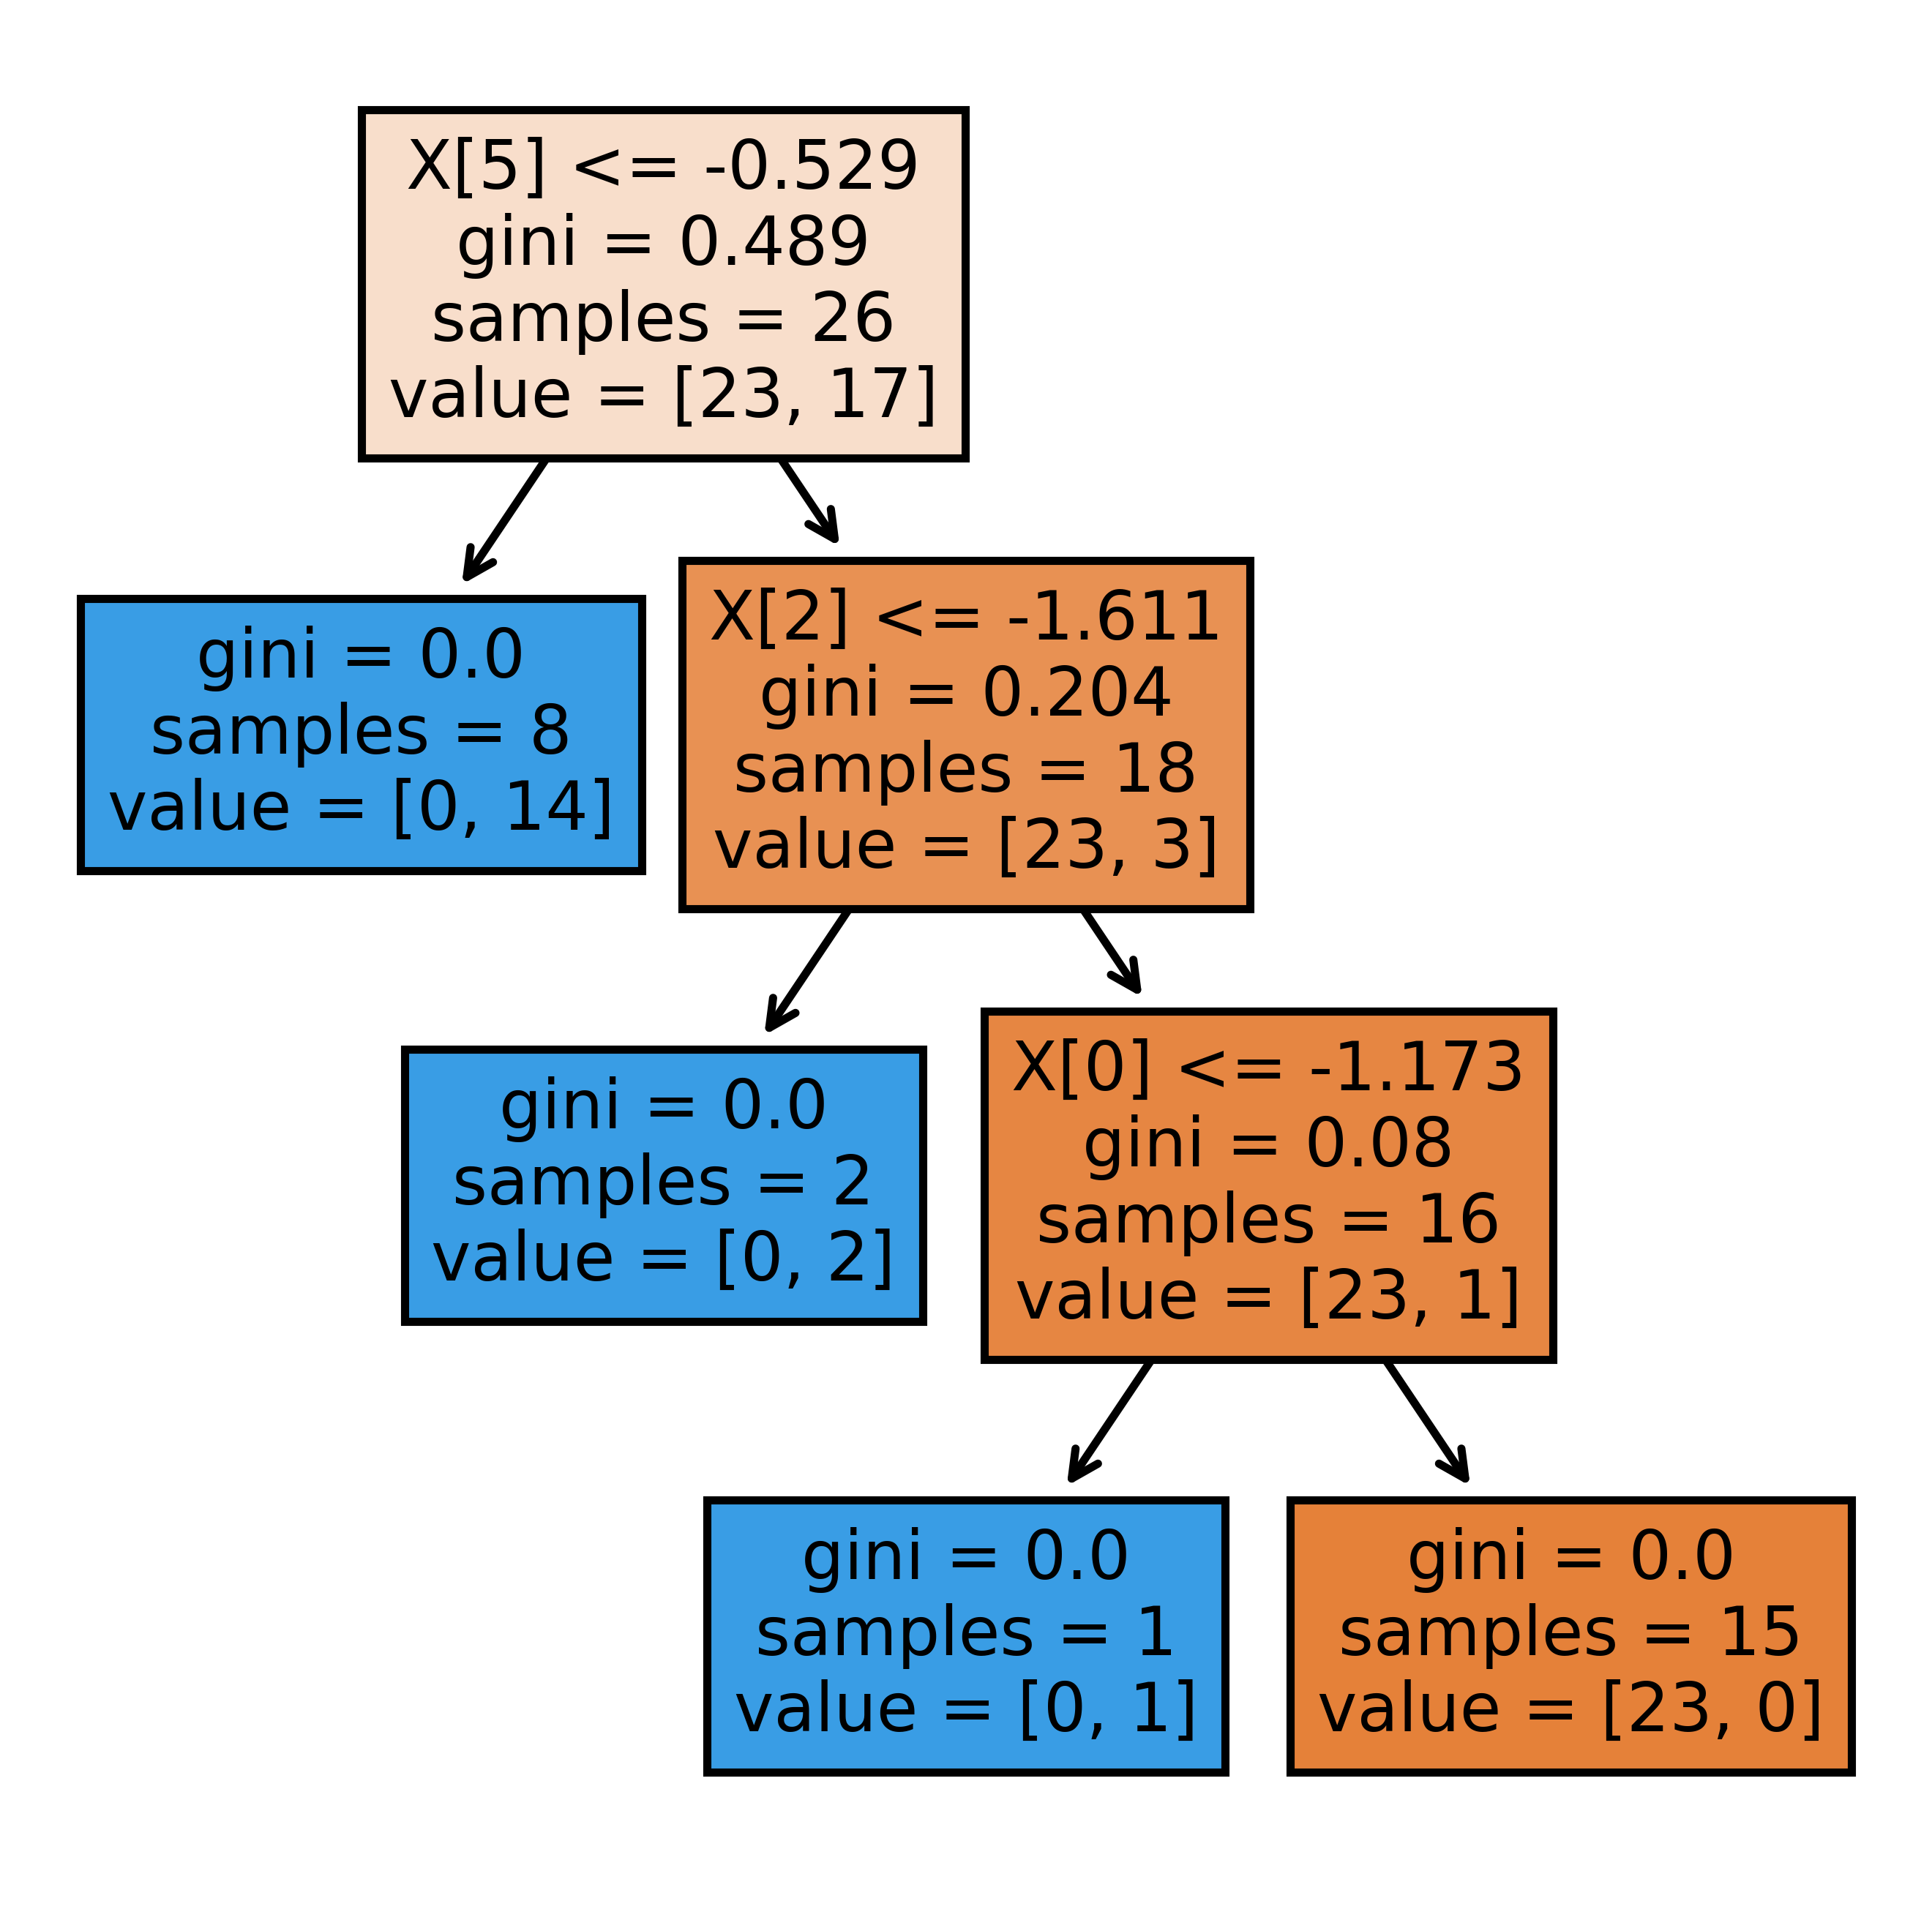

In [21]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf.estimators_[0], filled = True)

## Logistic Regression

In [37]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

log_reg_train_predictions = log_reg.predict(X_train)

log_reg_predictions = log_reg.predict(X_test)

log_reg_prediction_proba = log_reg.predict_proba(X_test)

In [40]:
print("Logistic Regression Results")
print("\nTraining:")
print("Accuracy:")
print(accuracy_score(y_train, log_reg_train_predictions))

print("\nMCC:")
print(matthews_corrcoef(y_train, log_reg_train_predictions))

print("\n\nTest:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, log_reg_predictions))
print("\nAccuracy:")
print(accuracy_score(y_test, log_reg_predictions))

print("\nMCC:")
print(matthews_corrcoef(y_test, log_reg_predictions))

Logistic Regression Results

Training:
Accuracy:
0.525

MCC:
0.0


Test:
Confusion Matrix:
[[ 9  0]
 [11  0]]

Accuracy:
0.45

MCC:
0.0


## Support Vector Machines

In [46]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)

svc_train_predictions = svc.predict(X_train)

svc_predictions = svc.predict(X_test)

svc_prediction_proba = svc.predict_proba(X_test)

In [47]:
print("Support Vector Classifier Results")
print("\nTraining:")
print("Accuracy:")
print(accuracy_score(y_train, svc_train_predictions))

print("\nMCC:")
print(matthews_corrcoef(y_train, svc_train_predictions))

print("\n\nTest:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, svc_predictions))
print("\nAccuracy:")
print(accuracy_score(y_test, svc_predictions))

print("\nMCC:")
print(matthews_corrcoef(y_test, svc_predictions))

Support Vector Classifier Results

Training:
Accuracy:
0.775

MCC:
0.5722633835193015


Test:
Confusion Matrix:
[[4 5]
 [4 7]]

Accuracy:
0.55

MCC:
0.08206099398622181


## Random Forest Classifier

In [50]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_train_predictions = rfc.predict(X_train)

rfc_predictions = rfc.predict(X_test)

rfc_prediction_proba = rfc.predict_proba(X_test)

In [51]:
print("Random Forest Classifier Results")
print("\nTraining:")
print("Accuracy:")
print(accuracy_score(y_train, rfc_train_predictions))

print("\nMCC:")
print(matthews_corrcoef(y_train, rfc_train_predictions))

print("\n\nTest:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, rfc_predictions))
print("\nAccuracy:")
print(accuracy_score(y_test, rfc_predictions))

print("\nMCC:")
print(matthews_corrcoef(y_test, rfc_predictions))

Random Forest Classifier Results

Training:
Accuracy:
1.0

MCC:
1.0


Test:
Confusion Matrix:
[[7 2]
 [4 7]]

Accuracy:
0.7

MCC:
0.41414141414141414
